# Spark using Google Colab

Reference guide:
- https://medium.com/analytics-vidhya/getting-started-spark3-0-0-with-google-colab-9796d350d78

## Environment preparation

### Installation

All the necessary packages

#### Java8

In [1]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

#### Spark (3.2.1)

We must first download spark

In [2]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

Let's unzip

In [3]:
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

#### findspark

In [4]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Configuration

#### Environment Variables

In [5]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

#### Init test

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3, False)

+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



Aaaand we check that we're using the wanted Spark's version

In [7]:
import pyspark

print(pyspark.__version__)

3.2.1


# MNIST Dataset using Artificial Neural Networks with Spark

[MNIST](http://yann.lecun.com/exdb/mnist/) is a Dataset created by Yann LeCun, Corinna Cortes and Christopher J.C. Burges.

It is a recopilation of handwritten digits. It is meant to be the "Hello World!" of Computer Vision, which is the ability of a computer to visually recognize.

The idea with this project is to try PySpark, and some other Neural Network libraries.

## Initialization

In this section, all the variables, basic libraries and elements, will be loaded (PySpark must be installed beforehand as it is a manual installation, rather than just an import)

In [8]:
TARGET_COL = '_c0' #@param {type:'string'}

### Imports

The Holy Trinity of Python's Data Science libaries, visualization, linear algebra and data manipulation

In [9]:
import pandas as pd
import numpy as np
THE_ANSWER_TO_LIFE = 42
np.random.seed(THE_ANSWER_TO_LIFE)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor

### Load the dataset

We load them as Spark DataFrames for our first test, spark has it's own reader which is meant to be ultra fast. Using all the elements given by a library is a good practice. The least I do myself, the less bugs my code will have

In [10]:
train_mnist_df = spark.read.csv('/content/sample_data/mnist_train_small.csv')
test_mnist_df = spark.read.csv('/content/sample_data/mnist_test.csv')

### Checking the datasets

Just a basic health check of the datasets

In [ ]:
train_mnist_df.head(5)

In [12]:
train_mnist_df.count()

20000

In [ ]:
test_mnist_df.head(5)

In [14]:
test_mnist_df.count()

10000

## Visualization

This would be the Exploratory Data Analysis, but we already know what's the content of the Dataset, which are digits, handwritten digits.

This section will also contain all of the main visualization helper functions that will be used all through the notebook.

### Configuration

The basic elements needed, and we also reload the datasets using Pandas because we'll not be using Spark for visualization, rather, another libraries that works wonderfully well with Pandas

In [15]:
df_train = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
df_test = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)

In [16]:
visualization_values = df_train[ list(range(1, len(df_train.columns))) ].values

### Helpers

With the following functions, we'll be able to plot in a grid some numbers to quickly gaze the performance of our Neural Networks.

Remaps an image into a 2D array

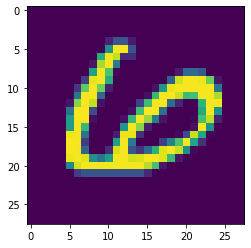

In [17]:
def to_img_array(
  row: pd.Series
) -> np.ndarray:
  return row.reshape((28, 28))

row = df_train[:1].values[0][1:]
plt.imshow(to_img_array(row))

Plots an image with all it's necessaries properties

In [18]:
def plot_image(
  index: int,
  values: np.ndarray,
  y_pred: np.ndarray,
  y_true: np.ndarray,
  ax
) -> None:
  ax.imshow(
    to_img_array( values[index] ),
    cmap='viridis',
    # cmap='gray',
  )
  # _ = ax.set_suptitle(f'The actual number was: {y_pred[img_index]}')
  # _ = ax.set_title(f'The predicted number was: {y_true[img_index]}')
  if y_pred is not None and y_true is not None:
    _ = ax.set_title(f'Actual: {y_true[index]} Predicted: {y_pred[index]}')

  # ax.set_xticklabels([])
  # ax.set_yticklabels([])

Plots a grid of images

In [19]:
def plot_img_grid(
  values: np.ndarray,
  y_pred: np.ndarray = None,
  y_true: np.ndarray = None,
  # n_imgs_to_display: int = 10,
  n_imgs_to_display: int = 25,
  # n_imgs_to_display: int = 20,
  n_cols: int = 8,
  fill_space: bool = True,
  randomized: bool = True,
) -> None:
  # number of rows and cols
  n_rows = ceil(n_imgs_to_display / n_cols)
  # n_rows = 2
  img_size = 5
  figsize = (img_size * n_cols, img_size * n_rows)

  # subplots configuration
  fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=figsize
  )
  # plt.subplots_adjust(wspace=0, hspace=0)
  print('Figsize', figsize)

  # indices
  total_imgs_to_display = n_cols * n_rows if fill_space else n_imgs_to_display
  indices = list(range(total_imgs_to_display)) if not randomized else np.random.randint(0, len(values), n_cols * n_rows)
  print('indices', indices)

  # subplot iterator
  for axis_index, img_index in enumerate(indices):
  # for axis_index, img_index in enumerate(range(n_imgs_to_display)):
    row_index = floor(axis_index / n_cols)
    col_index = floor(axis_index % n_cols)

    # print(img_index, row_index, col_index)

    plot_image(
      index=img_index,
      values=values,
      y_pred=y_pred,
      y_true=y_true,
      ax=axes[ row_index, col_index ]
    )

### Fixed numbers visualization

Having a fixed grid of numbers will help us catch bugs, if we have the same values all of the time, we can check them for reference, with just a gaze.

Figsize (40, 20)
indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


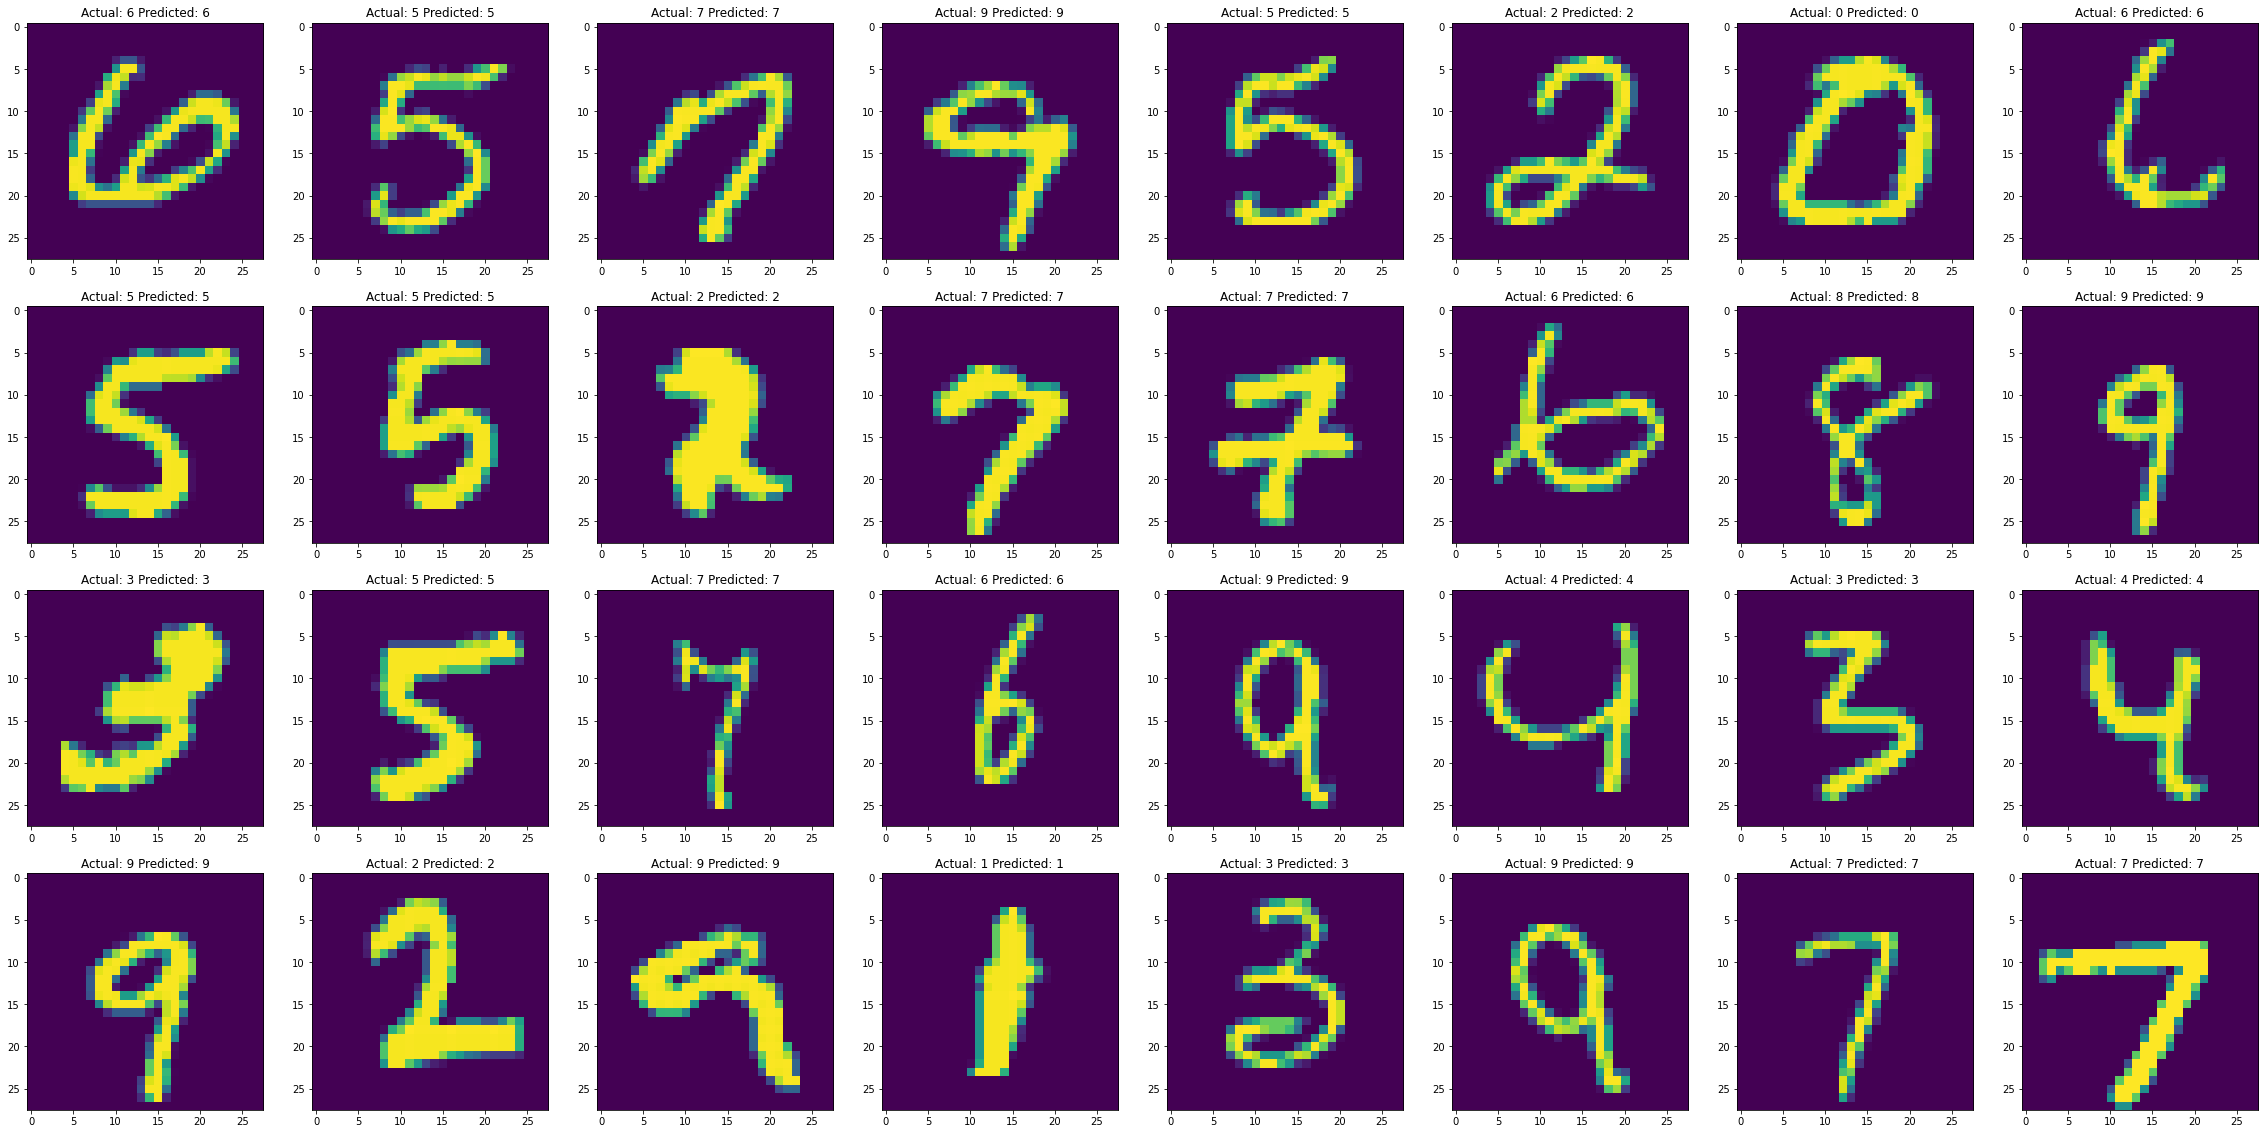

In [20]:
plot_img_grid(
  values=visualization_values,
  y_pred=df_train[0].values,
  y_true=df_train[0].values,
  fill_space=True,
  randomized=False,
)

### Random numbers visualization

While the fixed numbers are necessary, and good, having some random numbers help us prove that our model is, in fact, performing well, not just cheating.

Figsize (40, 20)
indices [15795   860  5390 11964 11284  6265 16850  4426 14423 11363 16023  8322
  1685   769  2433  5311  5051  6420 17568 19769  6396  8666 18942 18431
  2747   189 19118  3005  1899  1267 17912 11394]


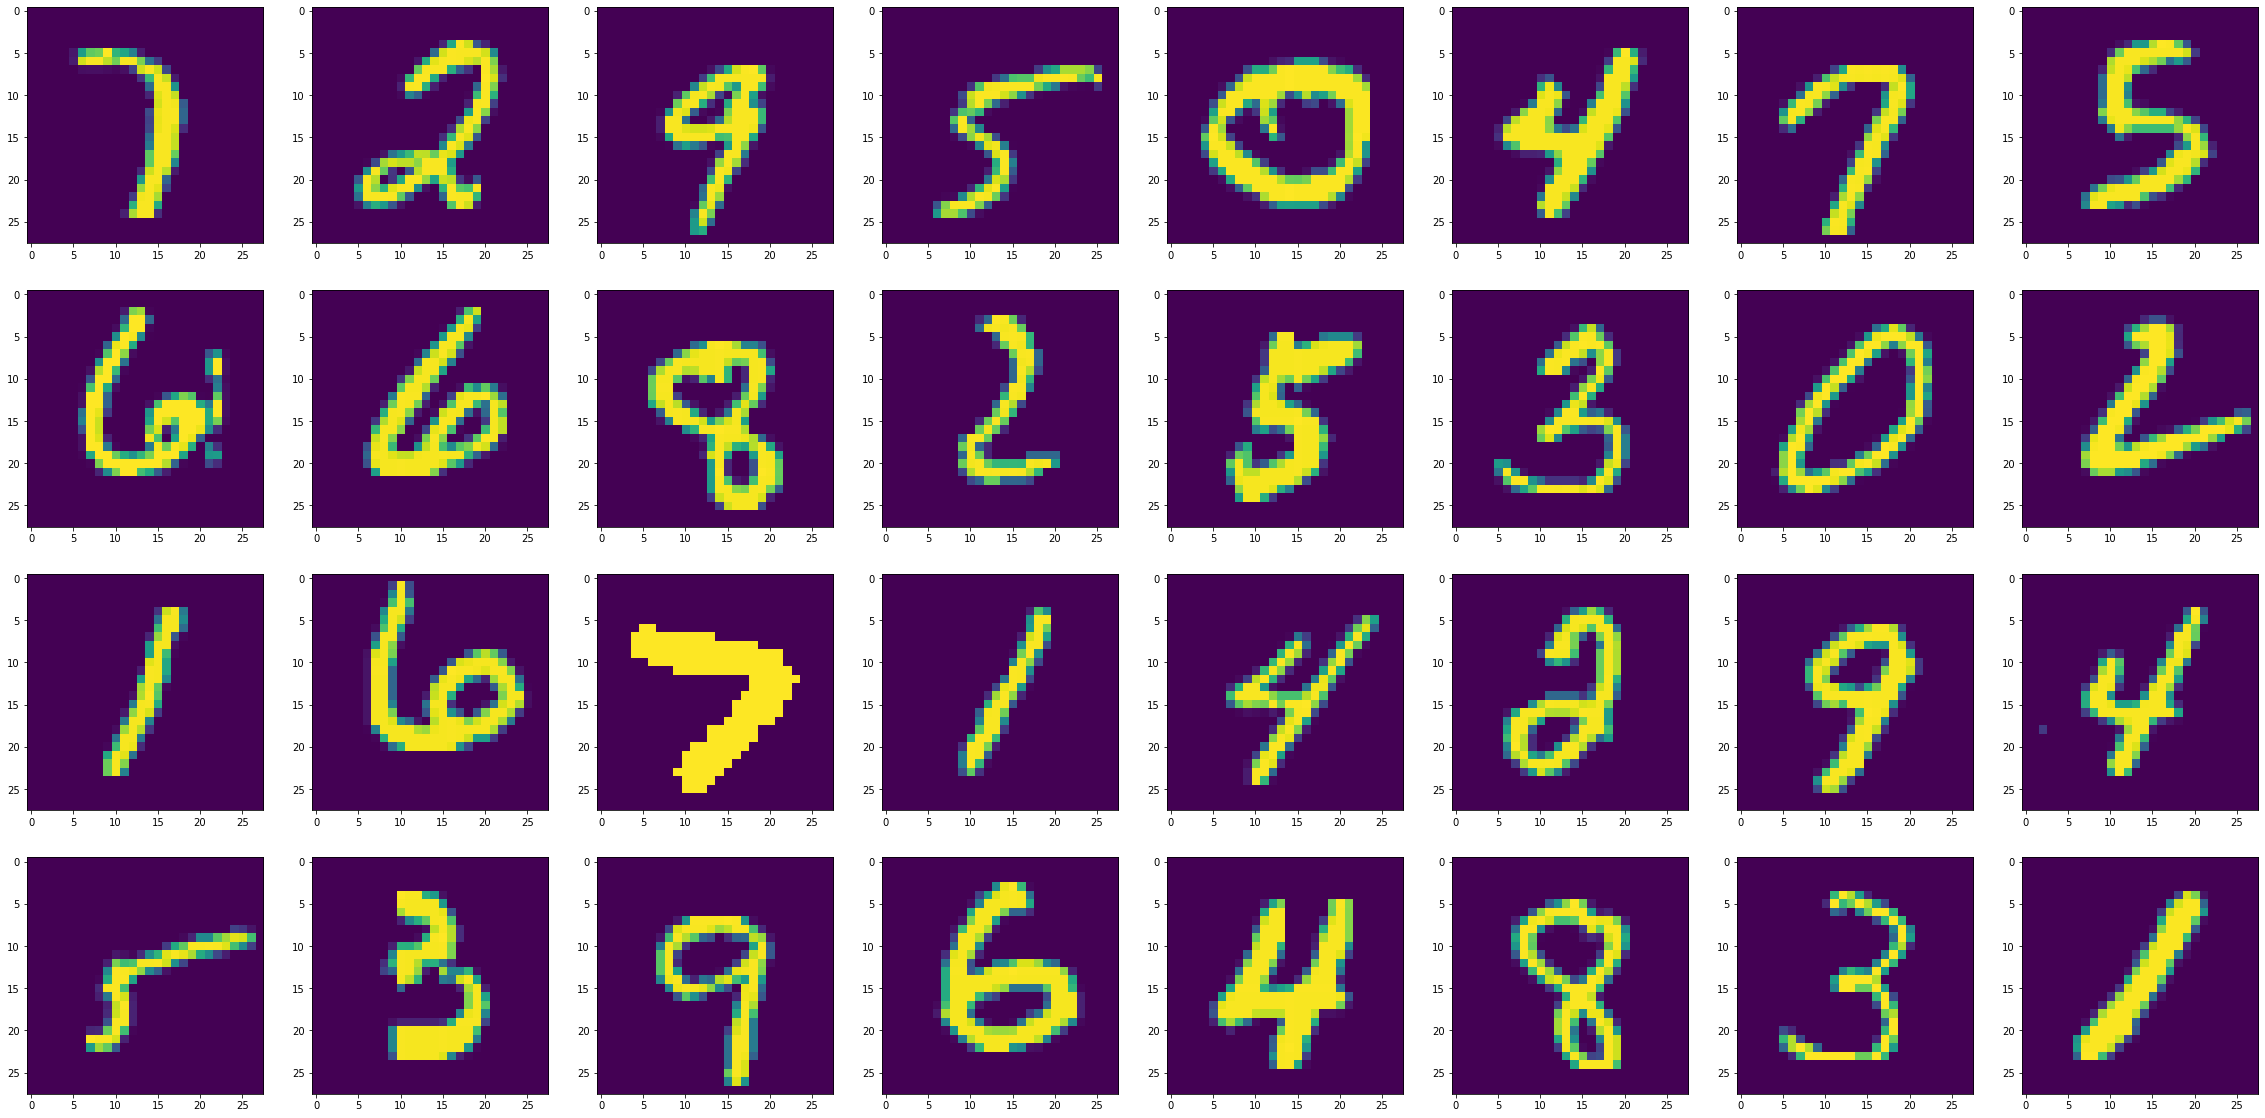

In [21]:
plot_img_grid(
  values=visualization_values,
  fill_space=True,
  randomized=True,
)

### Visualize an index

While random numbers are great, there's the possiility of ending up finding bugs, or edge cases, such as the following example, so being able to check those edge cases manually, is also a must.

In [22]:
df_train[0].values[16198]

0

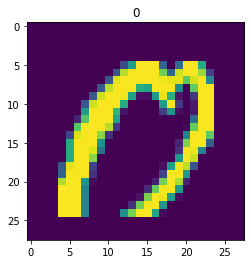

In [23]:
specific_index = df_train.values[16198]
digit = specific_index[1:]
label = specific_index[0]
plt.imshow(to_img_array(digit))
_ = plt.title(label)

In this example, the following digit, it's really weirdly shaped, there's a high change it ends up as a problematic case. But that's fine.

## Preparation

Before going hands on to modelling, we need to make sure that our data is ready for Spark to start processing it, as we need have numbers, and a vector of features per row.

In [24]:
l_train_mnist_df = train_mnist_df.withColumnRenamed(TARGET_COL, 'label')
l_test_mnist_df = test_mnist_df.withColumnRenamed(TARGET_COL, 'label')

### Retype the data values

Here we cast all of the values to integer, since we're not working with floats, at the moment

In [25]:
from pyspark.sql.functions import col

int_train_mnist_df = l_train_mnist_df.select([col(c).cast("int") for c in l_train_mnist_df.columns])
int_test_mnist_df = l_test_mnist_df.select([col(c).cast("int") for c in l_test_mnist_df.columns])

### Normalization

Data normalization is a crucial part of modelling, specially deep learning, all the values must be in the same scale, 0 to 1, so that the standard deviation is as minimal as possible, because it's how models best perform.

In this case, we're working with greyscale pixels, thus, 255 is that maximum number.

In [26]:
from pyspark.sql import functions as F

cols_to_normalize = int_train_mnist_df.columns[1:]

normalized_train_mnist_df = (
  int_train_mnist_df
  .withColumn(
    'arr',
    F.struct(
      *[
        (F.col(x) / 255.0).alias(x)
        for x in cols_to_normalize
      ]
    )
  )
  .select('label', 'arr.*')
)
normalized_test_mnist_df = (
  int_test_mnist_df
  .withColumn(
    'arr',
    F.struct(
      *[
        (F.col(x) / 255.0).alias(x)
        for x in cols_to_normalize
      ]
    )
  )
  .select('label', 'arr.*')
)

### Vectorizing the features

Spark works with features in a vector, at the column `features`, it's just how the framework works. And as we're using it, we need to adapt

In [27]:
from pyspark.ml.feature import VectorAssembler

ignore = [ 'label', ]
features_cols = [ col for col in normalized_train_mnist_df.columns if col not in ignore ]

assembler = VectorAssembler(
  inputCols=features_cols,
  outputCol='features'
)

vector_train_mnist_df = assembler.transform(normalized_train_mnist_df).drop(*features_cols)
vector_test_mnist_df = assembler.transform(normalized_test_mnist_df).drop(*features_cols)

### Explore the data

A basic exploration once again, just to check that the preprocessing worked successfully

The training dataset

In [ ]:
vector_train_mnist_df.head(5)

The features

In [ ]:
vector_train_mnist_df.select('features').head(5)

The testing dataset

In [ ]:
vector_test_mnist_df.head(5)

## Modelling

Now that we have the Data ready, we'll use neural networks architectures to predict the digit written in an image.

### Imports

In [31]:
from multiprocessing import cpu_count

We'll save the number of processors, just in case the notebook gets executed outside Google Colab, or using Google Colab Pro

In [32]:
PROCESSORS = cpu_count() - 1

### Neural Network with Spark (Multilayer Perceptron Classifier)

Neural Networks are a way to solve a problem in Data Science, said to be able to learn almost anything, they try to replicate the human brain.

A Perceptron is a neuron, well, it's computer scientific representation, input, processing, output.
And a Multilayer is when we have multiple perceptrons interconnected.

PySpark is the Python implementation of Spark, a parallelization framework, here it won't run that fast, since it's running multiple processes all at once, but it's reeeeaaalllyyyyy fast. Widely used under new names and implementations, such as Databricks, for example.

#### Imports

In [33]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Before we do anything, we must first define the number of columns, and number labels we want to predict

In [34]:
n_cols = len(features_cols)
print('n_cols', n_cols)
n_labels = 10 #@param {type:'number'}

n_cols 784


#### Architecture

The actual neural network's architecture.

If we were to increase the number of iterators, and the hidden layer's neurons, we could get a much higher score (close to perfect, 95% maybe even) but that may be an overfit score, and, given it's not a huge dataset, it takes more time.

In case you want to test it out, a high score was given with:

```python
maxIter=100,
layers=[
  ...,
  250,
  ...,
]
```

But the actual architecture used was:

In [96]:
trainer = MultilayerPerceptronClassifier(
  maxIter=100,
  # maxIter=25,
  layers=[
    n_cols, # input
    # 250, # hidden
    # 32, # hidden
    64, # hidden
    n_labels, # output
  ],
  blockSize=64,
  seed=THE_ANSWER_TO_LIFE
)

The model learning process itself

#### Training

Just a basic fit of our vectors

In [97]:
model = trainer.fit(vector_train_mnist_df)

#### Evaluation

PySpark provides a classification evaluator, in our case, we're trying to predict multiple outcomes, thus, we're working with a multiclass classificator

Let's prepare the evaluator, straight from the documentation

In [37]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

Predict the labels

In [98]:
train_result = model.transform(vector_train_mnist_df)
test_result = model.transform(vector_test_mnist_df)

In [94]:
test_result

DataFrame[label: int, features: vector, rawPrediction: vector, probability: vector, prediction: double]

And display the results

In [99]:
print('Train set accuracy =', evaluator.evaluate(train_result.select('prediction', 'label')))
print('Test set accuracy =', evaluator.evaluate(test_result.select('prediction', 'label')))

Train set accuracy = 1.0
Test set accuracy = 0.9523


#### Visualization

This section right here, to an almost identical point, will appear in the used Neural Networks

In [41]:
spark_test_df = test_result.select('features', 'prediction', 'label').toPandas()

In [42]:
spark_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   features    10000 non-null  object 
 1   prediction  10000 non-null  float64
 2   label       10000 non-null  int32  
dtypes: float64(1), int32(1), object(1)
memory usage: 195.4+ KB


In [43]:
spark_features_values = np.array(list(map(lambda x: x.toArray(), spark_test_df['features'])))

First, the fixed view

Figsize (40, 20)
indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


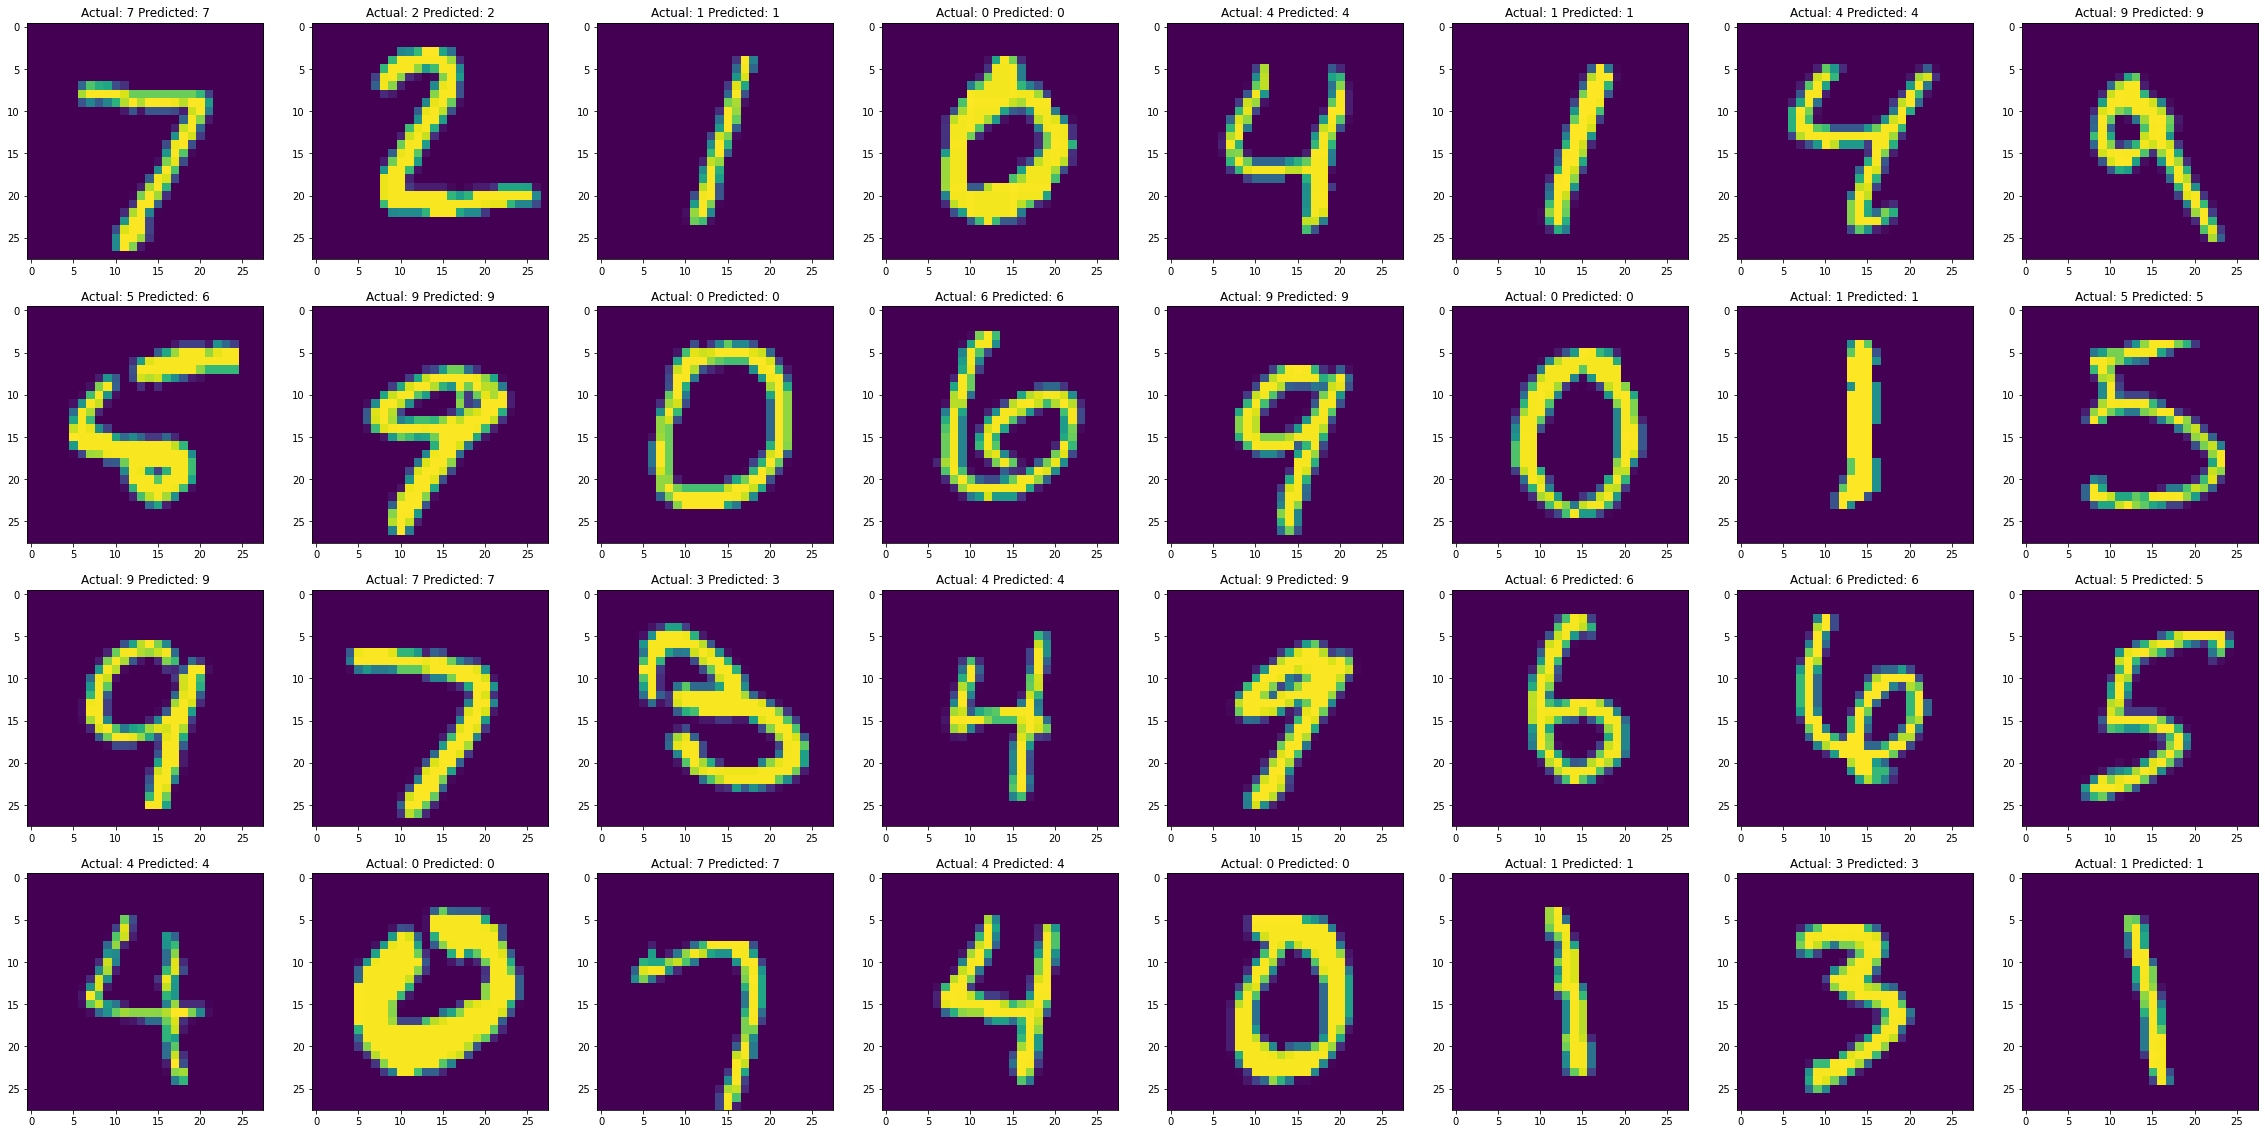

In [44]:
plot_img_grid(
  values=spark_features_values,
  y_pred=spark_test_df['prediction'].apply(int),
  y_true=spark_test_df['label'],
  fill_space=True,
  randomized=False,
)

Then with random values

Figsize (40, 20)
indices [3556 3890 8838 5393 8792 8433 7513 2612 7041 9555 6235 5486 7099 9670
  775 8226 3152 1585 3943 7555 3073 1021 3843 7989 9692 6873 5675  161
 4297  995 7629 9467]


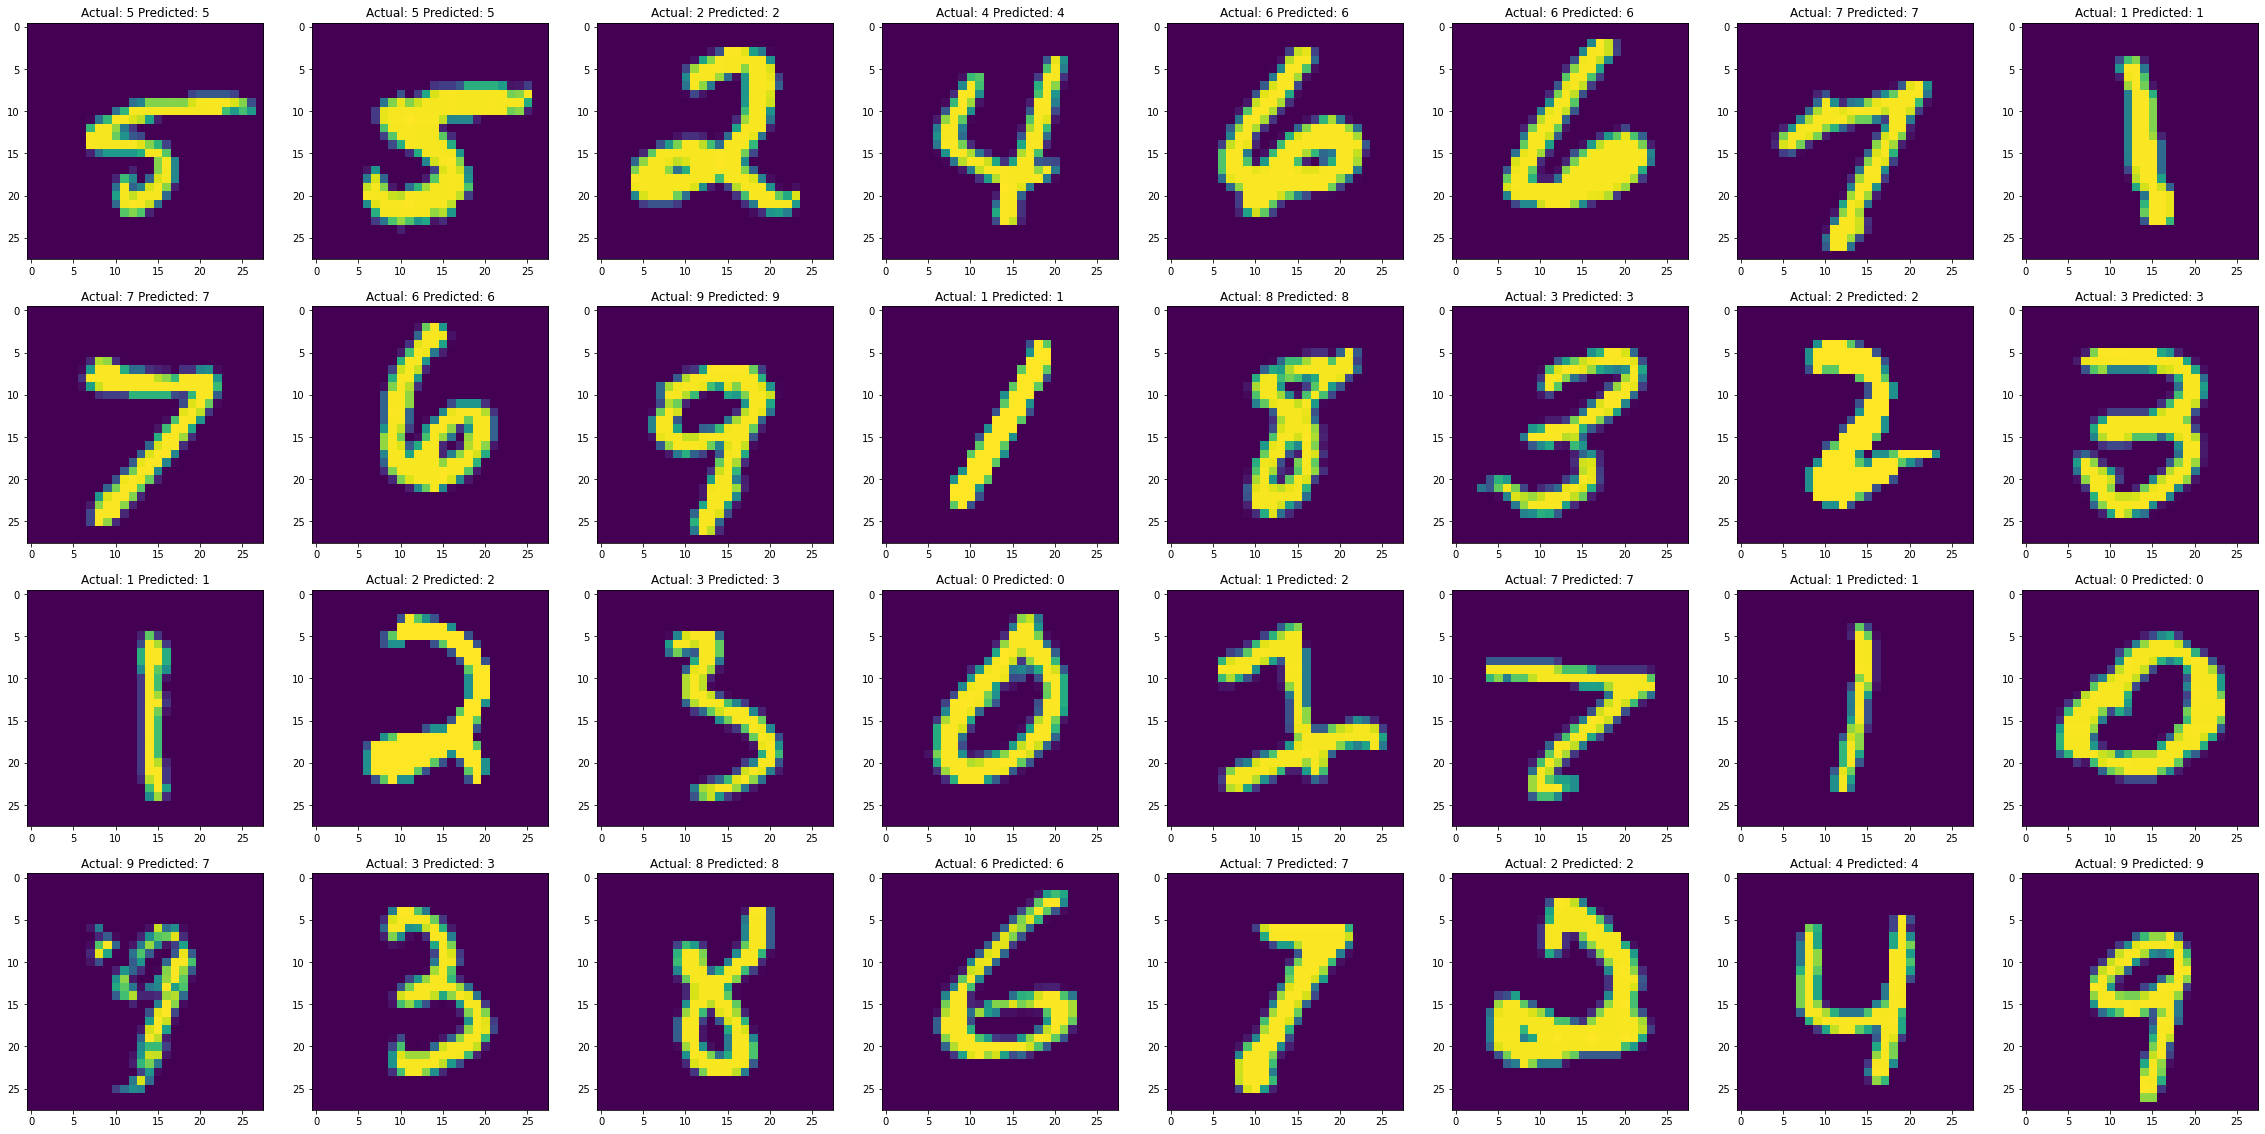

In [45]:
plot_img_grid(
  values=spark_features_values,
  y_pred=spark_test_df['prediction'].apply(int),
  y_true=spark_test_df['label'],
  fill_space=True,
  randomized=True,
)

Let's see PySpark's performance on the aforementioned edge case

In [46]:
train_result.select('prediction', 'label').collect()[16198]

Row(prediction=0.0, label=0)

### Neural Network with Tensorflow and Keras

Tensorflow and Keras are one of the most used Deep Learning Python libraries, if not the most, it's a really easy way to handle and configure the neural network architecture. Efficient. And with plenty of utilities. It is also easy to read, which adds points.

And is the one I have more experience with

In [47]:
SCALE_PREDICTOR_VALUES = False #@param {type:'boolean'}
SCALE_DEPENDANT_VALUE = False #@param {type:'boolean'}

#### Imports

We must first import Tensorflow, which already includes Keras

In [48]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical 

#### Reread the CSVs

We already have readed them, but we'll also be mapping them this time around

In [49]:
df_train = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
df_test = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)

In [50]:
tf_train_cols = list(df_train.columns)[1:]
# tf_train_cols

In [51]:
def cast_to_number(x):
  return [ int(y) for y in x ]

# training set
X_tf_train = df_train[ tf_train_cols ].apply(
  pd.to_numeric
  # cast_to_number
)
y_tf_train = to_categorical(df_train[ 0 ])

# test set
X_tf_test = df_test[ tf_train_cols ].apply(
  pd.to_numeric
  # cast_to_number
)
y_tf_test = to_categorical(df_test[ 0 ])

#### Normalization

In this case, we can directly apply a numpy transformation, which reads cleanlier

Normalize the predictors values

In [52]:
if SCALE_PREDICTOR_VALUES:
  tf_max = X_tf_train.max()
  tf_min = X_tf_train.min()

  X_tf_train = (X_tf_train - tf_min) / (tf_max - tf_min)
  X_tf_test = (X_tf_test - tf_min) / (tf_max - tf_min)

# Given that it's a greyscale image, it should be divided by 255
X_tf_train = X_tf_train / 255
X_tf_test = X_tf_test / 255

And normalize the dependant variables

In [53]:
if SCALE_DEPENDANT_VALUE:
  y_tf_std = y_tf_train.std()
  y_tf_mean = y_tf_train.mean()

  y_tf_train = (y_tf_train - y_tf_std) / (y_tf_mean)
  y_tf_test = (y_tf_test - y_tf_std) / (y_tf_mean)

#### Architecture

And build the architecture of our model

```python
# the number of inputs
Input layer: 784
# half, not to loss information
Second Layer: 382
# a second layer for extra processing
Third Layer: 196
# the number of labels
Output Layer: 10
```

Which would translate to:

In [54]:
tf_model = tf.keras.Sequential(
  name='MNIST-Dense-Model',
  layers=[
    tf.keras.layers.Dense(
      name='Input-Layer',
      units=len(tf_train_cols),
      input_shape=(len(tf_train_cols),),
      activation='relu',
    ),
    tf.keras.layers.Dense(
      name='First-Hidden-Layer',
      units=int( len(tf_train_cols) / 2 ), # effective, but a little bit slow
      activation='relu',
      kernel_regularizer='l2',
    ),
    tf.keras.layers.Dense(
      name='Second-Hidden-Layer',
      units=int( len(tf_train_cols) / 4 ), # effective, but a little bit slow
      activation='relu',
      kernel_regularizer='l1',
    ),
    tf.keras.layers.Dense(
      name='Output-Layer',
      units=y_tf_test.shape[1],
      activation='softmax',
    ),
  ]
)

Compiling the model let us establish the optimizer and loss function, and, in case we want, we can even add some metrics

In [55]:
tf_model.compile(
  # loss=tf.losses.CategoricalCrossentropy(),
  loss='categorical_crossentropy',
  # optimizer=tf.optimizers.Adam(
  #   learning_rate=0.01
  # ),
  optimizer='adam',
  metrics=['accuracy']
)

And the explenation of the model

In [56]:
tf_model.summary()

Model: "MNIST-Dense-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (Dense)         (None, 784)               615440    
                                                                 
 First-Hidden-Layer (Dense)  (None, 392)               307720    
                                                                 
 Second-Hidden-Layer (Dense)  (None, 196)              77028     
                                                                 
 Output-Layer (Dense)        (None, 10)                1970      
                                                                 
Total params: 1,002,158
Trainable params: 1,002,158
Non-trainable params: 0
_________________________________________________________________


#### Training

Finally, we train the model

In [57]:
history = tf_model.fit(
  X_tf_train,
  y_tf_train,
  epochs=10,
  validation_split=.2,
  callbacks=[
    tf.keras.callbacks.EarlyStopping(
      patience=3,
    ),
  ],
  use_multiprocessing=True,
  workers=PROCESSORS,
)

Epoch 1/10
500/500 [==============================] - 10s 18ms/step - loss: 4.6087 - accuracy: 0.8616 - val_loss: 0.7839 - val_accuracy: 0.9045
Epoch 2/10
500/500 [==============================] - 9s 17ms/step - loss: 0.6423 - accuracy: 0.9230 - val_loss: 0.5743 - val_accuracy: 0.9273
Epoch 3/10
500/500 [==============================] - 9s 18ms/step - loss: 0.5072 - accuracy: 0.9415 - val_loss: 0.4823 - val_accuracy: 0.9488
Epoch 4/10
500/500 [==============================] - 9s 18ms/step - loss: 0.4298 - accuracy: 0.9533 - val_loss: 0.4270 - val_accuracy: 0.9455
Epoch 5/10
500/500 [==============================] - 9s 17ms/step - loss: 0.3935 - accuracy: 0.9610 - val_loss: 0.4146 - val_accuracy: 0.9510
Epoch 6/10
500/500 [==============================] - 8s 17ms/step - loss: 0.3593 - accuracy: 0.9652 - val_loss: 0.3730 - val_accuracy: 0.9563
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.3420 - accuracy: 0.9701 - val_loss: 0.3504 - val_accuracy: 0.959

We can actually see how it performed over the epochs

In [58]:
df_tf_history = pd.DataFrame(history.history)

The decrease of the loss

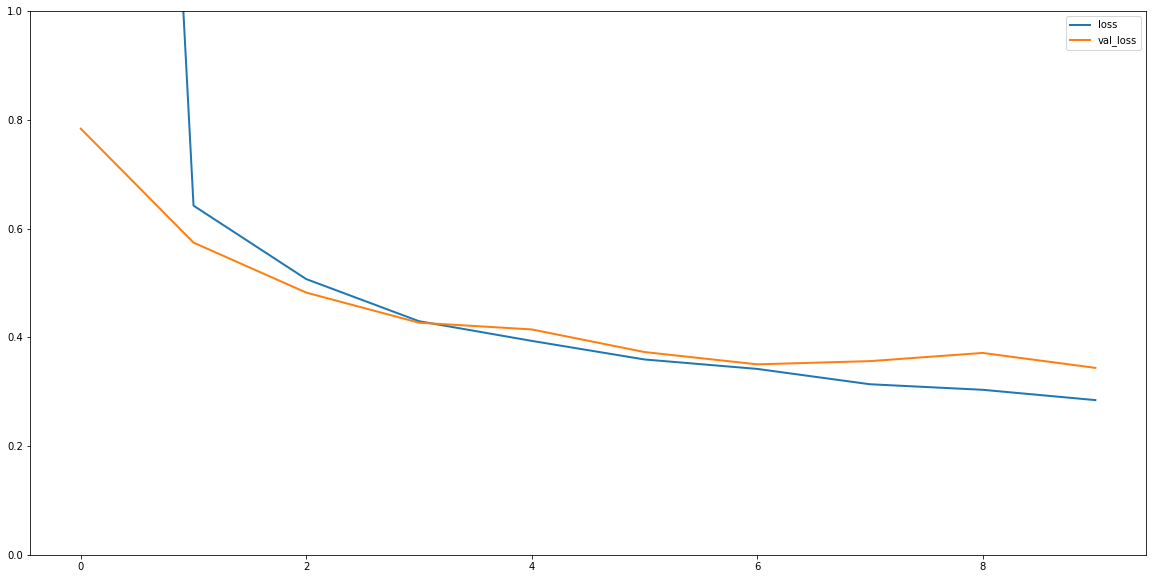

In [59]:
_ = df_tf_history[ ['loss', 'val_loss'] ].plot(figsize=(20,10), ylim=(0, 1), lw=2)

The progress of the accuraccy

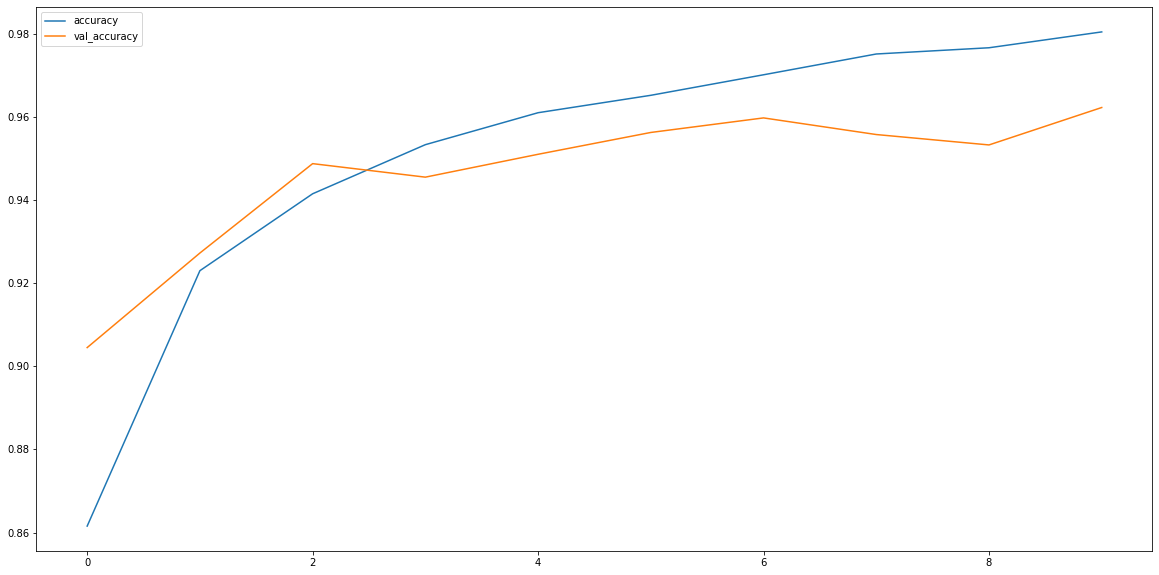

In [60]:
_ = df_tf_history[ ['accuracy', 'val_accuracy'] ].plot(figsize=(20,10))

The zoomed-out progress

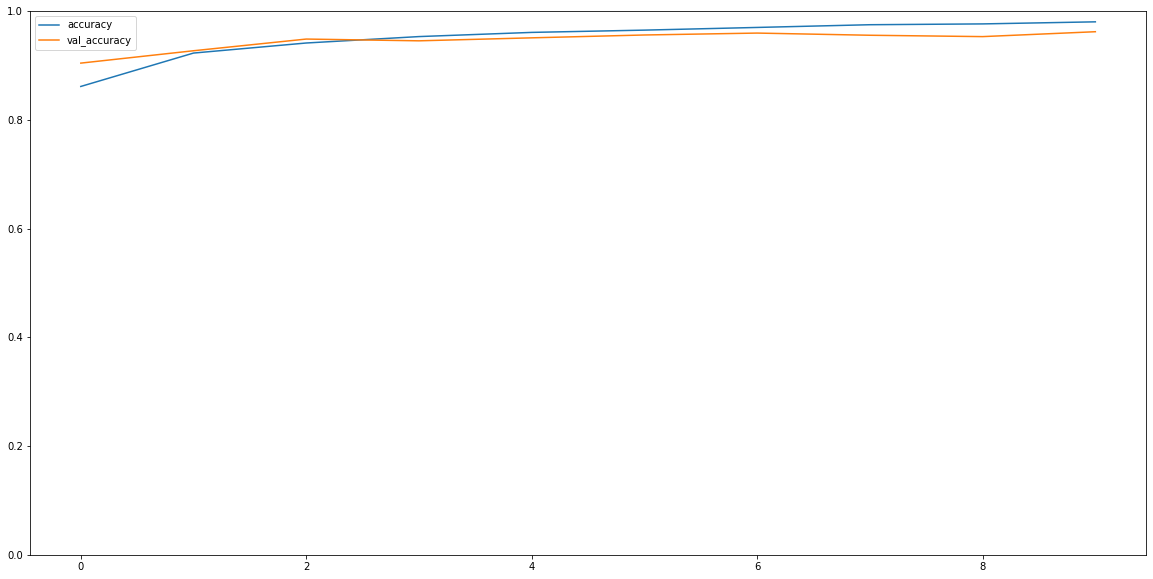

In [61]:
_ = df_tf_history[ ['accuracy', 'val_accuracy'] ].plot(figsize=(20,10), ylim=(0,1))

#### Evaluation

Given that we're using Keras, with classification, we can actually evaluate the accuracy metric

In [62]:
tf_train_evaluation = tf_model.evaluate(X_tf_train, y_tf_train)
tf_test_evaluation = tf_model.evaluate(X_tf_test, y_tf_test)

313/313 [==============================] - 6s 18ms/step - loss: 0.3449 - accuracy: 0.9640


In [63]:
print('Train set accuracy =', tf_train_evaluation[1])
print('Test set accuracy =', tf_test_evaluation[1])

Train set accuracy = 0.9807000160217285
Test set accuracy = 0.9639999866485596


#### Visualization

In [64]:
y_pred = np.argmax(tf_model.predict(df_test[ tf_train_cols ]), axis=-1)
y_true = np.argmax(y_tf_test, axis=-1)

In [65]:
tf_test_values = X_tf_test.values

First with the normal order of pictures, as a bullet-proof method

Figsize (40, 20)
indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


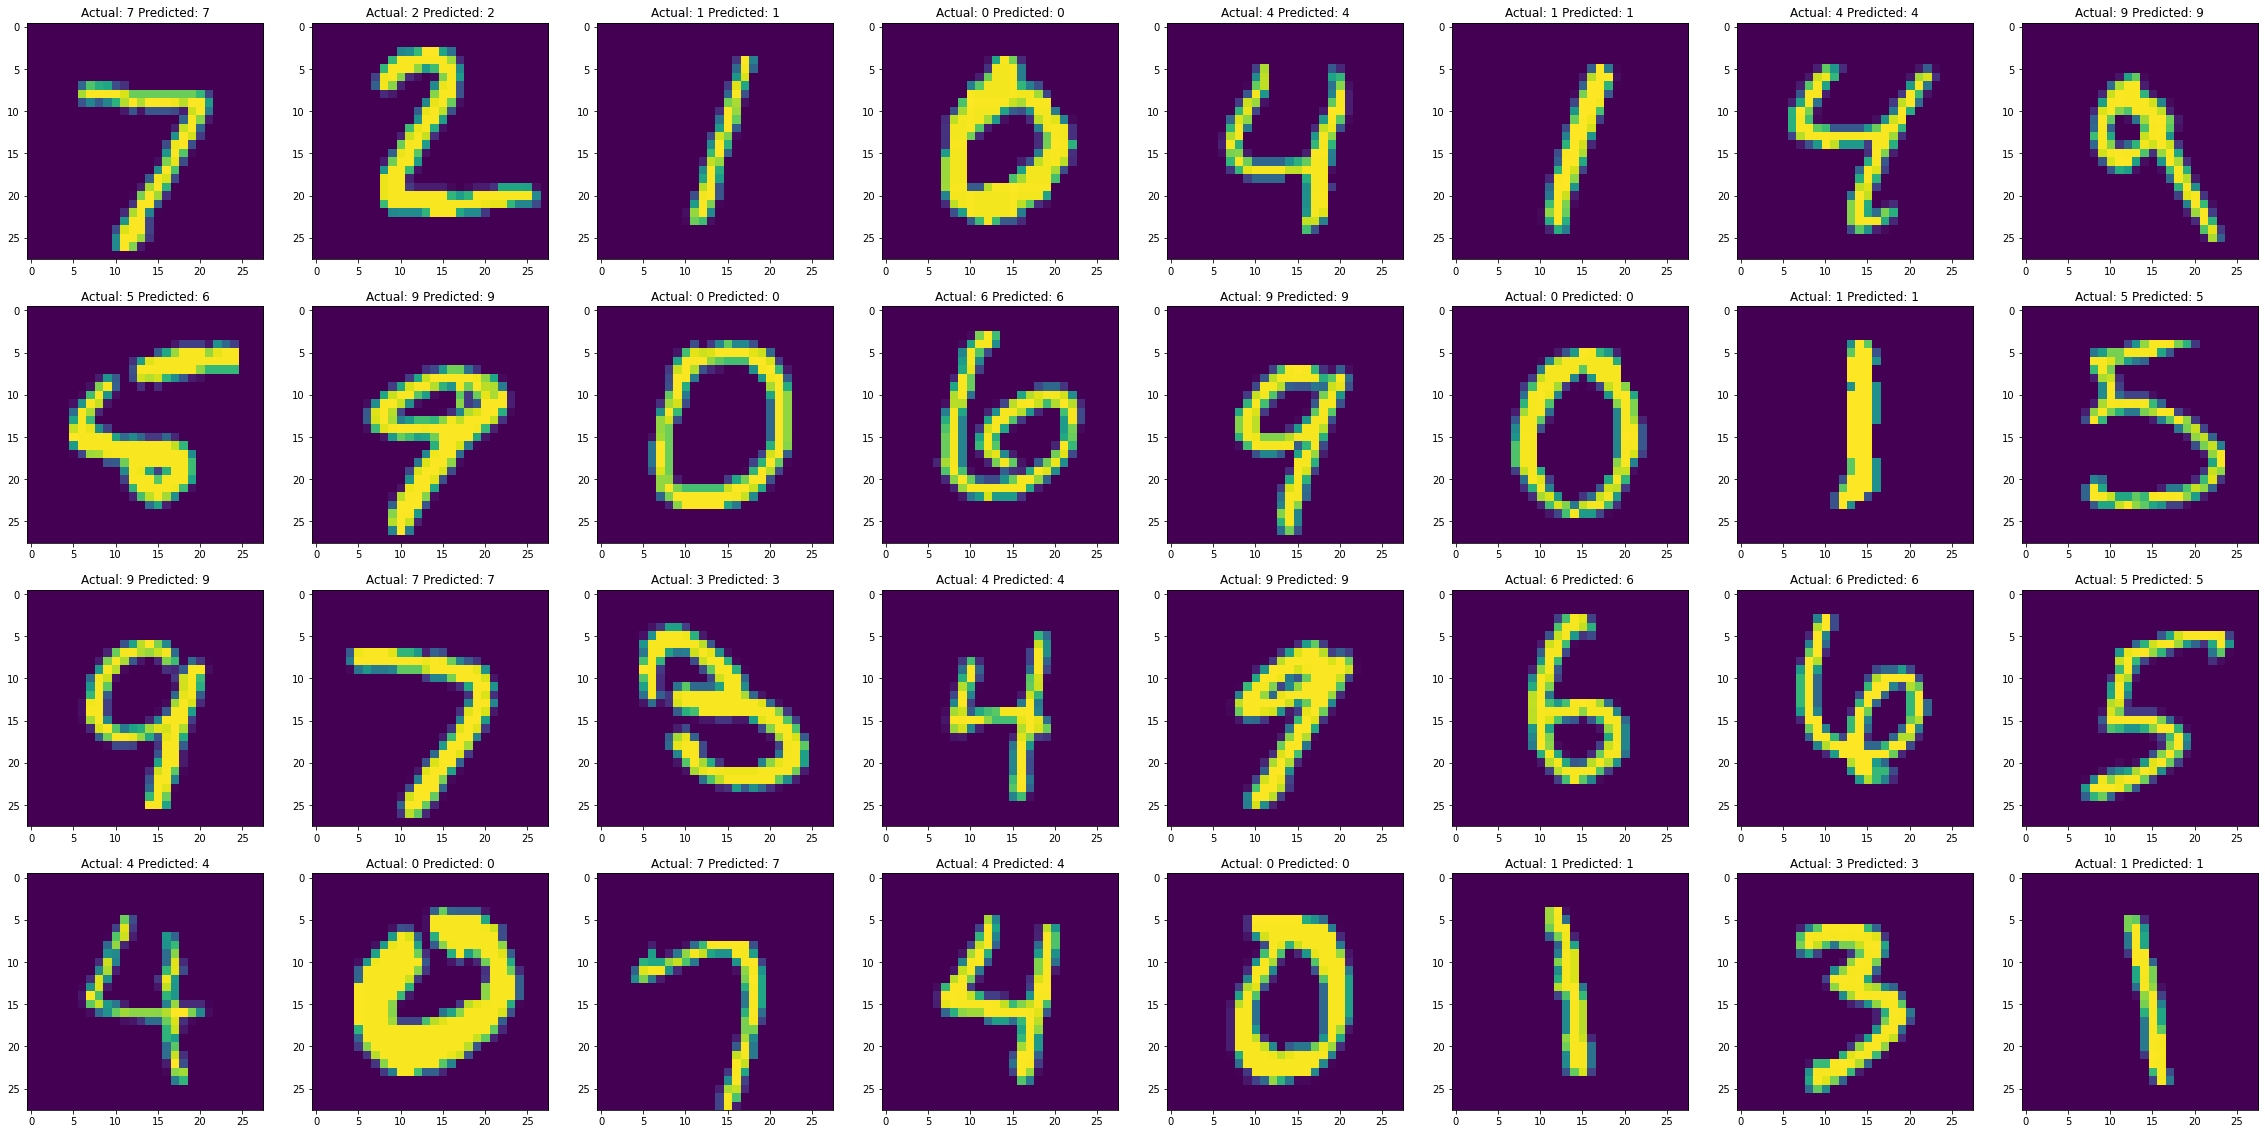

In [66]:
plot_img_grid(
  values=tf_test_values,
  y_pred=y_pred,
  y_true=y_true,
  fill_space=True,
  randomized=False,
)

Then with some random elements

Figsize (40, 20)
indices [1016 7869 6439 7892 6863 7916 8529  878 9268 4887 4859 6331 8571 8684
 7208 5276 2062   64 8006 2568 5463 2027 2695 9687 5258 5618 6736  391
 5892 3561 6184 3099]


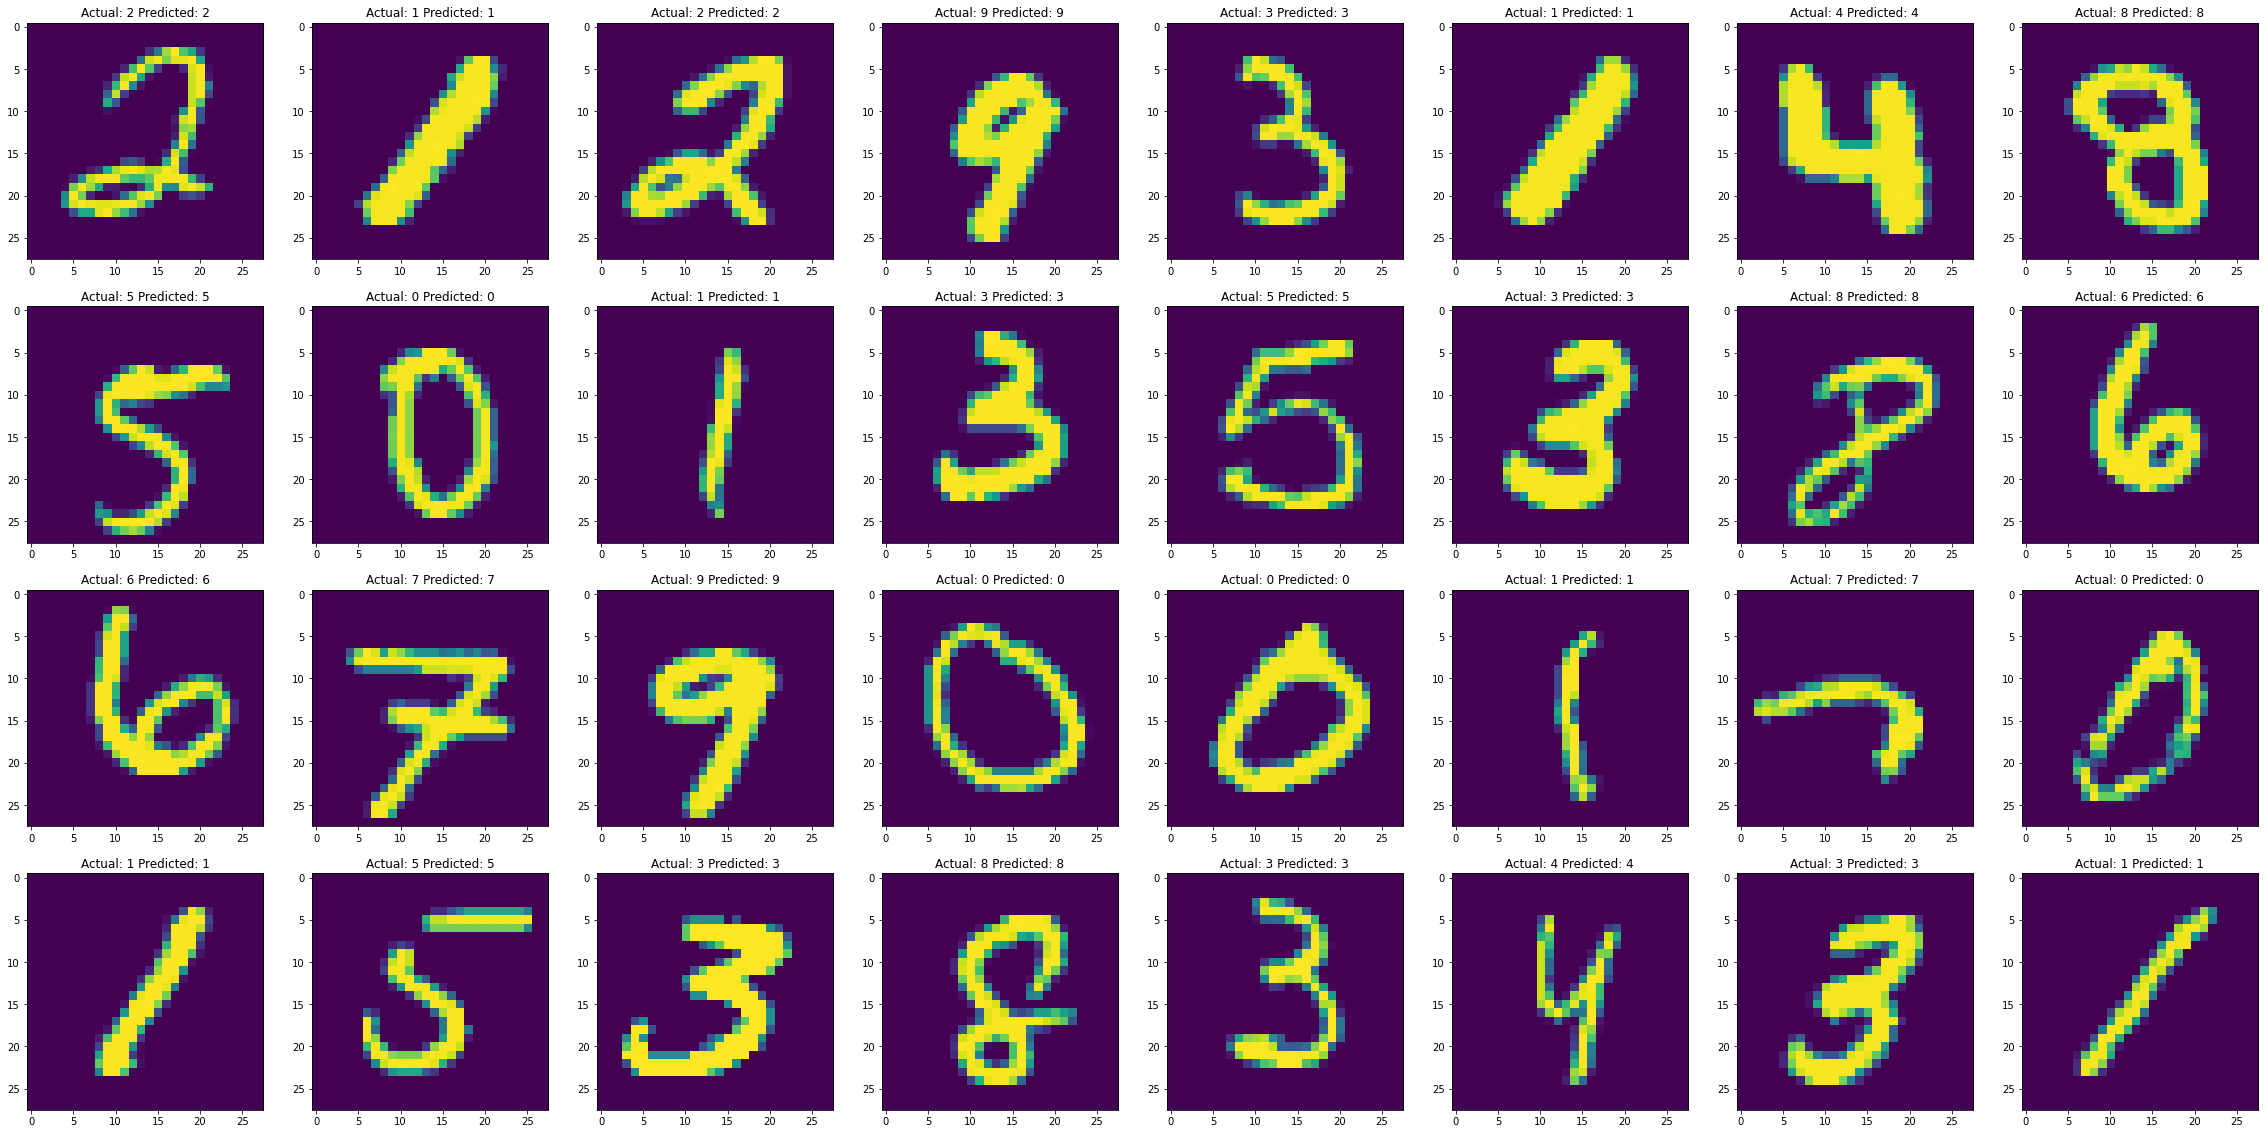

In [67]:
plot_img_grid(
  values=tf_test_values,
  y_pred=y_pred,
  y_true=y_true,
  fill_space=True,
  randomized=True,
)

Let's see how well Keras handled the edge case

In [68]:
np.argmax(tf_model.predict(X_tf_train[16198:16198 + 1]), axis=-1)[0], np.argmax(y_tf_train[16198: 16198+1], axis=-1)[0]

(0, 0)

### Neural Network using PyTorch

PyTorch is the library I've barely used, but it's known to be used for academic purposes, and ready for production, obviously.

It's an object-oriented approach to Deep Learning, with a little bit more of boiler plate code and manual implementations. It does not have some of the utilities PySpark, Tensorflow and Keras provide. But it does wonders

In [69]:
classes = list(range(0, 10))

#### Imports

In [70]:
import torch
import torchvision
import torchvision.transforms as transforms

Check the configuration to see if we can use GPU

In [71]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


#### Prepare the loaders/datasets

It is important once again to work with the normalized data, otherwise we may confuse our model and it would be much harder to learn properly

In [72]:
def df_to_tensor(
  df: pd.DataFrame
) -> torch.tensor:
  return torch.from_numpy(df.values).float().to(device)

torch_scaled_train = df_train.copy()
torch_scaled_train[ tf_train_cols ] = X_tf_train.copy()

torch_scaled_test = df_test.copy()
torch_scaled_test[ tf_train_cols ] = X_tf_test.copy()

train_tensor = df_to_tensor(torch_scaled_train)
test_tensor = df_to_tensor(torch_scaled_test)

#### Architecture

The architecture used here will be the same than the one used with the Keras Model, it's just for showcase purpose

```python
# the number of inputs
Input layer: 784
# half, not to loss information
Second Layer: 382
# a second layer for extra processing
Third Layer: 196
# the number of labels
Output Layer: 10
```

The (Convolutional) Neural Network, straight from the documentation:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#train-the-network

In [73]:
import torch.nn as nn
import torch.nn.functional as F

n_features = len(tf_train_cols)
first_hidden_layer_neurons = int( n_features / 2 )
second_hidden_layer_neurons = int( n_features / 4 )

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # self.conv1 = nn.Conv2d(3, 6, 5)
    # self.pool = nn.MaxPool2d(2, 2)
    self.input_layer = nn.Linear(
      n_features,
      first_hidden_layer_neurons
    )
    self.hidden_layer = nn.Linear(
      first_hidden_layer_neurons,
      second_hidden_layer_neurons
    )
    self.output_layer = nn.Linear(
      second_hidden_layer_neurons,
      len(classes)
    )

  def forward(self, x):
    # x = self.pool(F.relu(self.conv1(x)))
    # x = self.pool(F.relu(self.conv2(x)))
    # x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_layer(x))
    x = self.output_layer(x)
    return x

net = Net()

The optimizer and loss functions

In [74]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

#### Training

After a couple of attempts, a single epoch turned out to be the best option for a decent score

In [75]:
torch_history = []

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for index, data in enumerate(train_tensor, 0):
      # get the inputs; data is a list of [inputs, labels]
      labels = data[0].long()
      inputs = data[1:]
      # print(inputs)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if index % 2000 == 1999:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {index + 1:5d}] loss: {running_loss / 2000:.3f}')
          torch_history.append([epoch + 1, index + 1, running_loss / 2000])
          running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.713
[1,  4000] loss: 0.419
[1,  6000] loss: 0.327
[1,  8000] loss: 0.241
[1, 10000] loss: 0.257
[1, 12000] loss: 0.215
[1, 14000] loss: 0.206
[1, 16000] loss: 0.202
[1, 18000] loss: 0.181
[1, 20000] loss: 0.207
Finished Training


After the training, we could sort of mimic the Keras' History object to see it's evolution through the epochs

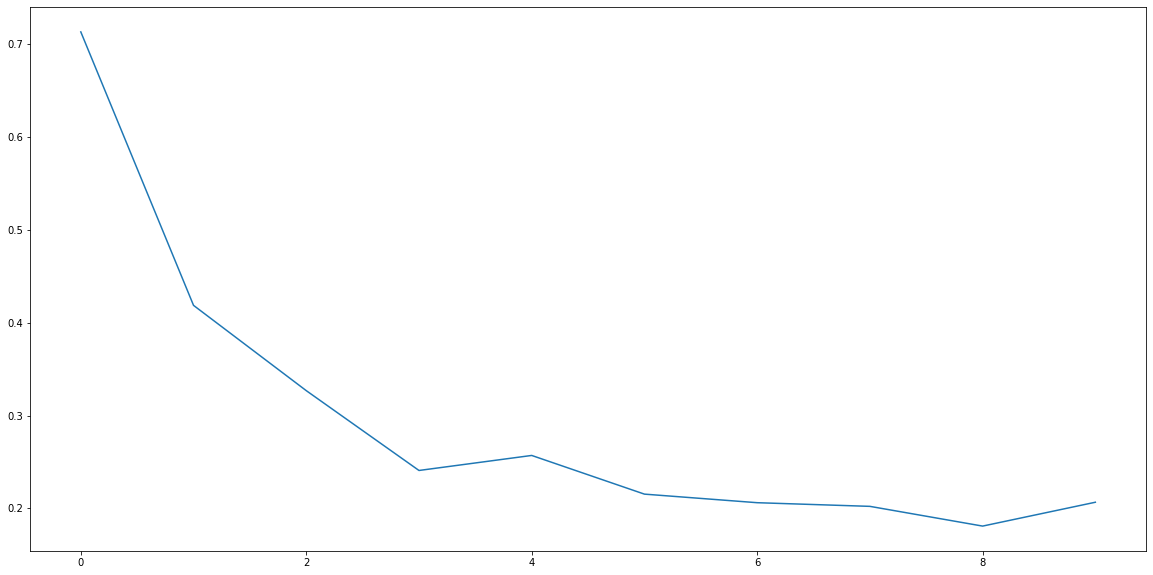

In [76]:
torch_history_df = pd.DataFrame(torch_history, columns=['epochs', 'batch_index', 'running_loss'])
_ = torch_history_df['running_loss'].plot(figsize=(20, 10))

Save the trained model

In [77]:
PATH = './mnist_net.pth'
torch.save(net.state_dict(), PATH)

#### Evaluation

The evaluation in PyTorch is a manual process

In [78]:
correct = 0
total = 0
torch_pred = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_tensor:
        labels = data[0].long()
        images = data[1:]
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs.data)
        torch_pred.append(predicted)
        total += 1
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {correct * 100 // total} %')

Accuracy of the network on the 10000 test images: 95 %


In [86]:
correct / total

0.9506

In [90]:
torch_train_correct = 0
torch_train_total = 0
torch_train_pred = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_tensor:
        labels = data[0].long()
        images = data[1:]
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs.data)
        torch_train_pred.append(predicted)
        torch_train_total += 1
        torch_train_correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {total} train images: {correct * 100 / total} %')

Accuracy of the network on the 10000 test images: 95.06 %


In [79]:
y_torch_pred = list(map(lambda x: int(x), torch_pred))
len(y_torch_pred)

10000

#### Visualization

It helps identify any problem

First, the overall, fixed, grid of numbers

Figsize (40, 20)
indices [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


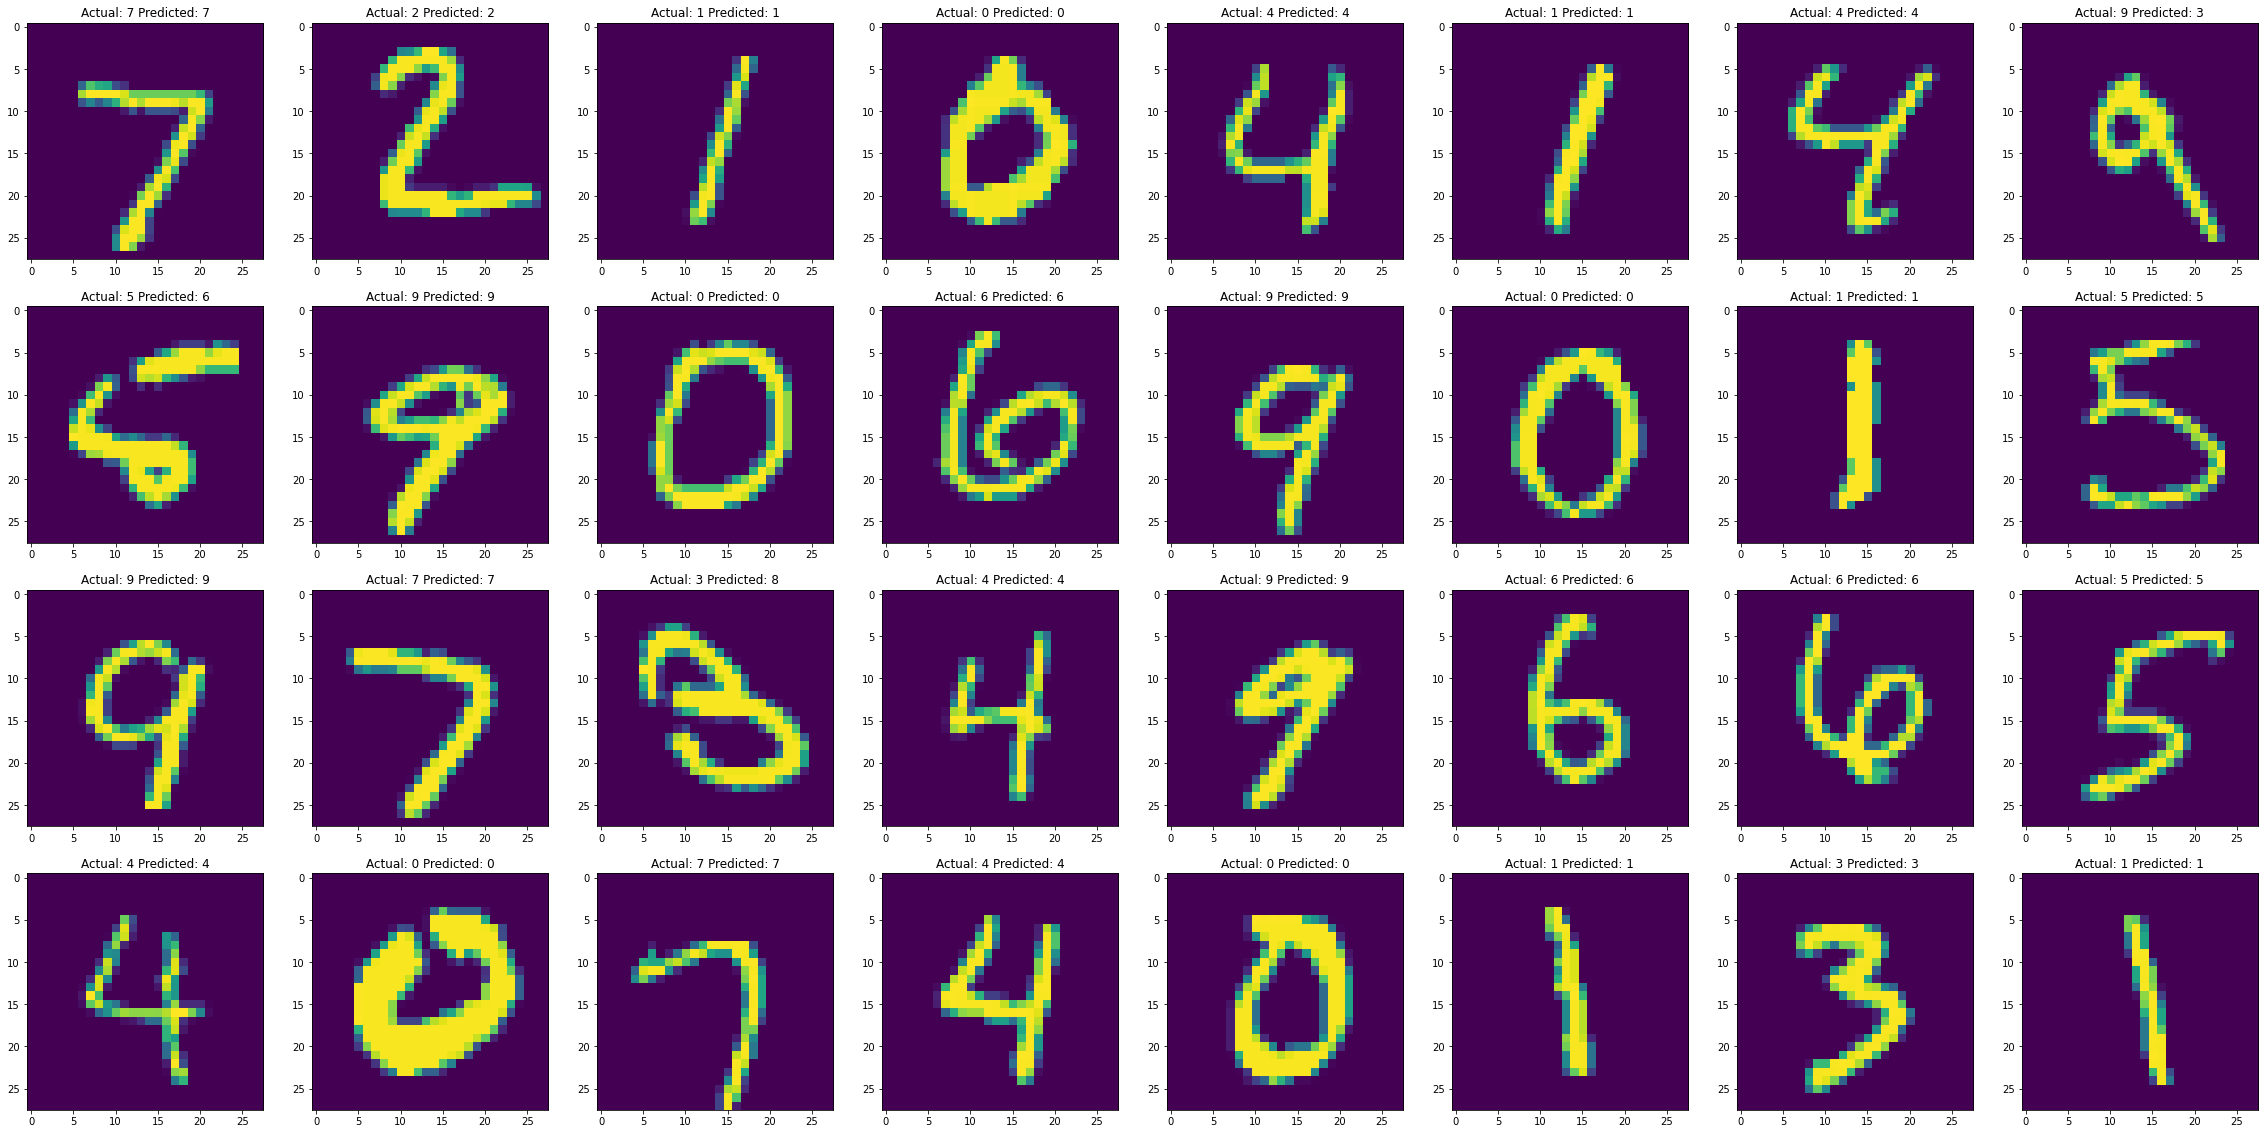

In [80]:
plot_img_grid(
  values=tf_test_values,
  y_pred=y_torch_pred,
  y_true=y_true,
  fill_space=True,
  randomized=False,
)

And then some random numbers to spice it up

Figsize (40, 20)
indices [6278 8392 3104 7215 2454 8996 2731 8154 9762 5056 8110 3840 1028 7385
  502 6910 9062 6938 4488  206 5134 5977 7721 7035 1484 7858  863 2790
 7408 8755 5116 6019]


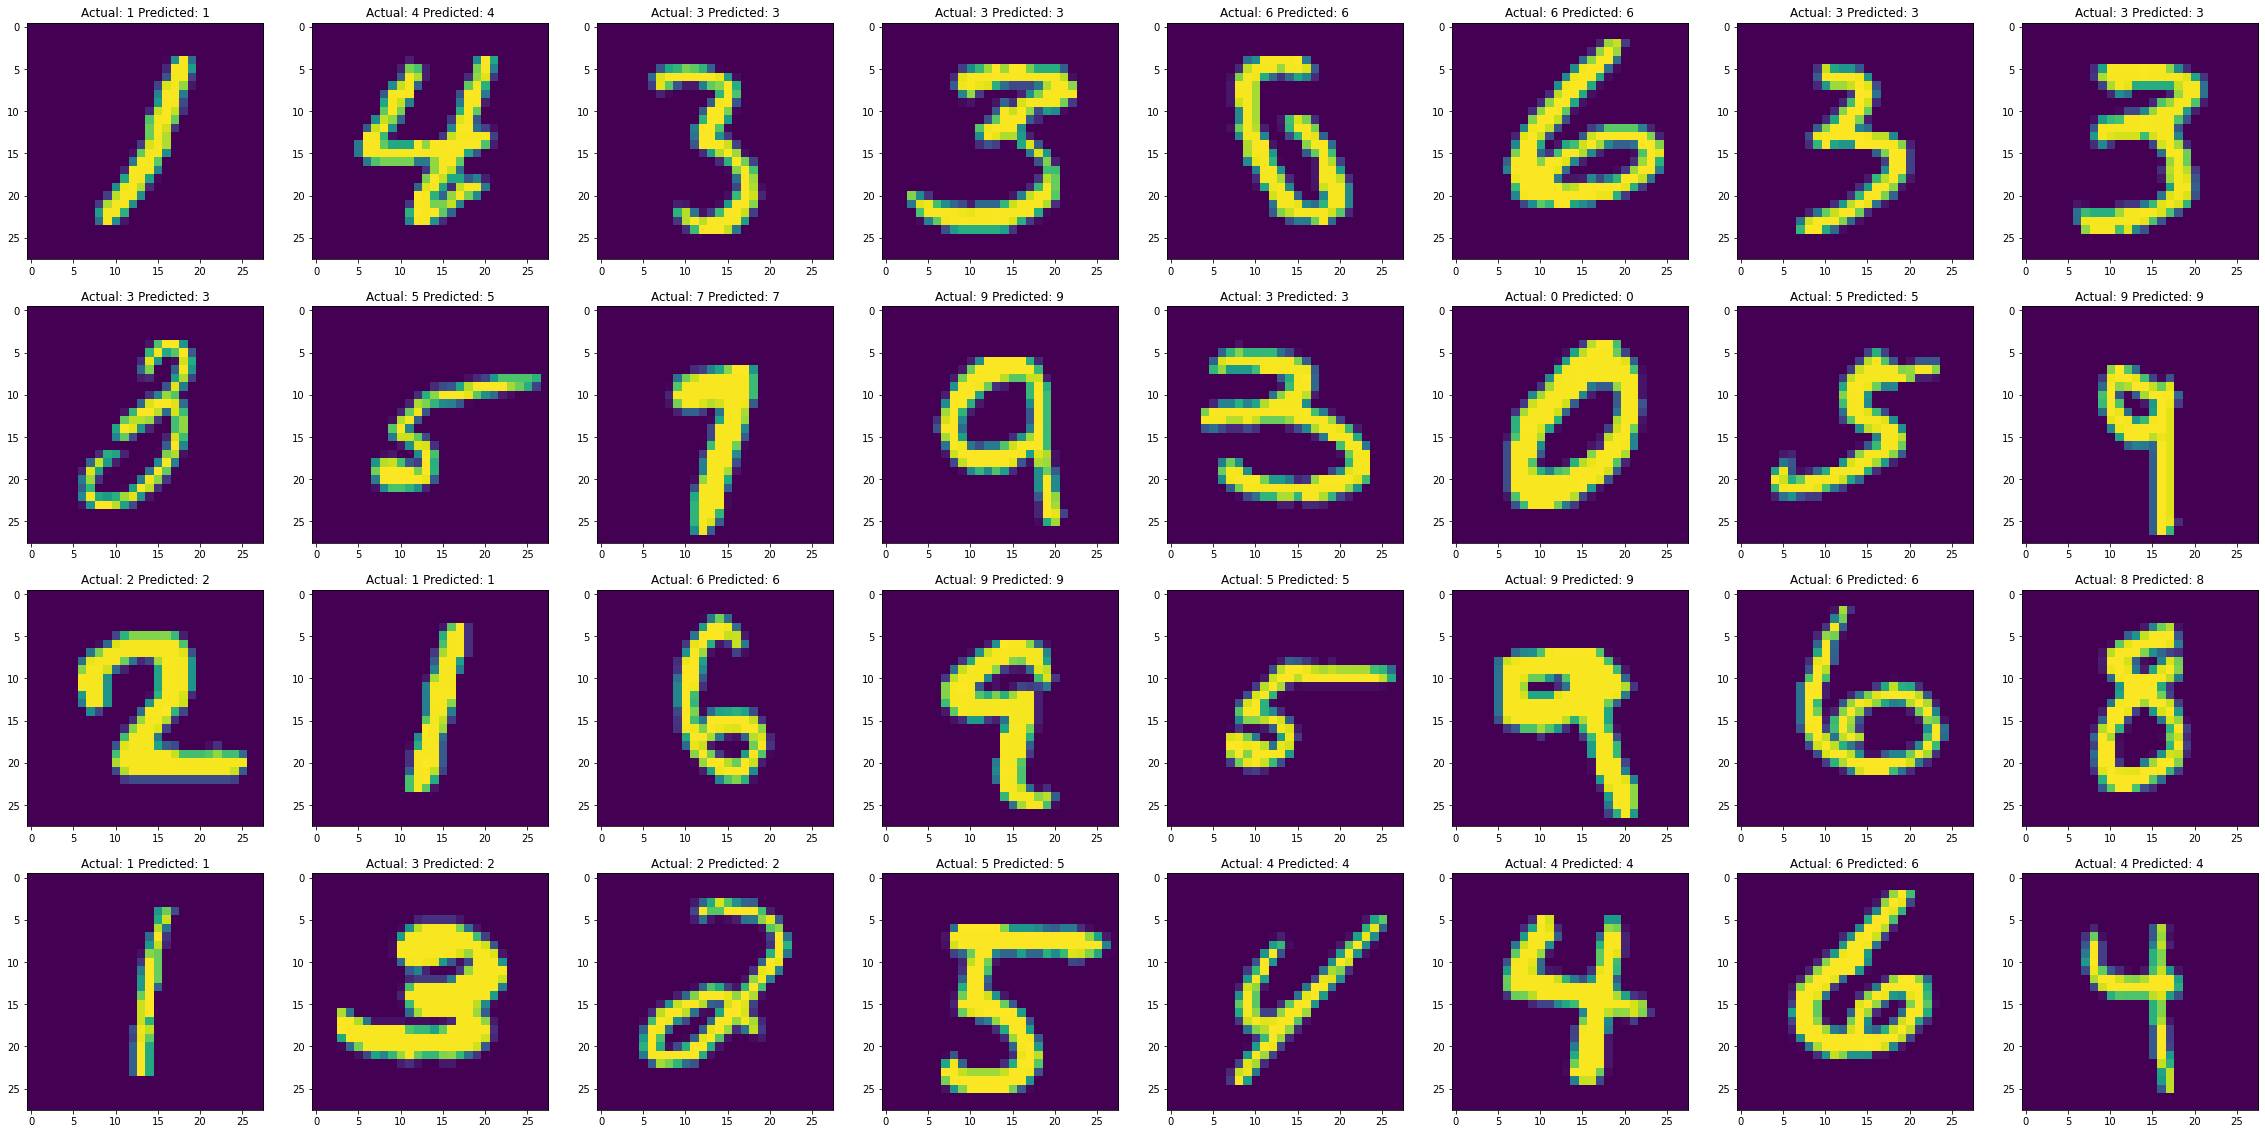

In [81]:
plot_img_grid(
  values=tf_test_values,
  y_pred=y_torch_pred,
  y_true=y_true,
  fill_space=True,
  randomized=True,
)

And lastly, let's see PyTorch's edge case resolution

In [82]:
torch_mapped_edge_case = list(map(lambda x: int(x), train_tensor[16198][1:]))

In [83]:
torch_tensor_edge_case = df_to_tensor(pd.DataFrame([torch_mapped_edge_case,]))

In [84]:
torch_probability_edge_case = net(torch_tensor_edge_case)
torch_probability_edge_case

tensor([[-1.2640, -0.2600, -0.6830,  0.2879, -1.0823,  0.3904, -1.0086, -0.9759,
         -0.4642, -0.8556]], grad_fn=<AddmmBackward0>)

In [85]:
torch.argmax(torch_probability_edge_case), train_tensor[16198][0]

(tensor(5), tensor(0.))

## Conclusions

As a recapitulation. We tried to build a neural network able to recognize a single digit in a 28x28 picture.

For that, we've used:

- PySpark Multilayer Perceptron Classifier (95.23%)
- Tensorflow basic Deep Learning Classifier (96.39%)
- PyTorch Neural Network Classifier (95.06%)

Tensorflow was, by far, the fastest one, and the one with the highest score, it is also the one I have more experience with and the one I know how to take into account more factors of the problem.

PySpark, given that it's not running at it's fullest potential, it performed great, and with such a high score. It was less code than the Tensorflow, and I know for a fact, that with more experience, it could be even less.

PyTorch, it was a nice experiment, but it seems like too high-level to build even the most basic architectures, but I suppose that this just scratched it's surface.

As demonstrated, you don't need a complex architecture to get results, and computers, given a preparation, are able to understand and recognize visual elements.

This is a really great example, that's not how the real world problems are presented, but still, it provides some proof of the possibilities to come.